In [1]:
import torchaudio
import noisereduce as nr
import torch as tr
import matplotlib.pyplot as plt

C:\Users\Joseph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
x1, sr = torchaudio.load('../normalized/sensor_1.wav')
x2, sr = torchaudio.load('../normalized/sensor_2.wav')
x3, sr = torchaudio.load('../normalized/sensor_3.wav')

X = tr.concat([x1, x2, x3], dim=0)
N = len(X[0])
X = tr.concat([x1, x2, x3], dim=0)[:,-N//4:]
N = len(X[0])

n = 3
tt = tr.arange(N) / sr

In [3]:
def long_or(a, w):
    w = int(w)
    y = tr.zeros(a.shape)
    for i in range(w, a.shape[0]-w , w//4):
        y[i-w:i+w] = True in a[i-w:i+w]
    return y

In [4]:
def moving_average(samples, window_size):
    # samples: (..., time)
    y = []
    for j in range(samples.shape[0]):
        for i in range(-window_size//2, window_size//2):
            y.append(tr.roll(samples[j], i, dims=0))
    return tr.mean(tr.row_stack(y), dim=0, keepdim=True)

In [5]:
def windows(length, window_size):
    for j in range(0, length, window_size):
        yield j, j + window_size - 1

# Frequency Range Preprocessing

In [6]:
# https://seaindia.in/blogs/human-voice-frequency-range/
X = torchaudio.functional.lowpass_biquad(X, sr, 3500)
X = torchaudio.functional.highpass_biquad(X, sr, 80)

# Agreement Weighted Average ?

torch.Size([1, 2398943]) torch.Size([3, 2398943])


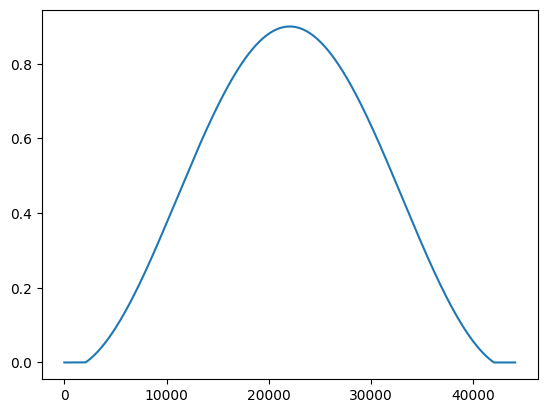

In [7]:
x_smooth = moving_average(X, 10)
X_disagree = X - x_smooth

print(x_smooth.shape, X_disagree.shape)

W = tr.zeros((3, N))

l = int(1 * sr)
h = tr.clamp(tr.reshape(tr.hamming_window(l), (1,-1)) - .1, 0, 1)
plt.plot(h.T)

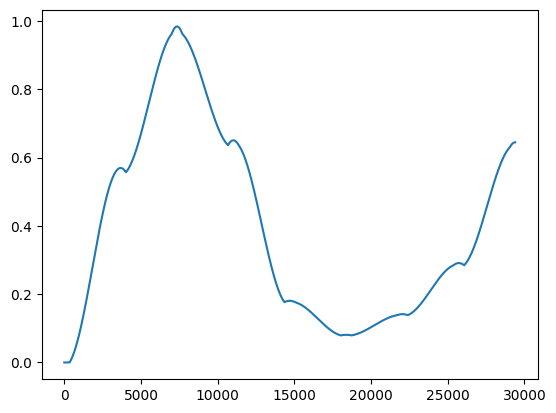

In [8]:
ii = tr.arange(l//2, N-l//2, l//2)
for i, j in zip(ii-l//2, ii+l//2):
    i = int(max(0, i))
    j = int(min(N-1, j))
    E = tr.sqrt(tr.mean(tr.square(X_disagree[:, i:j]),axis=1, keepdim=True))
    W[:,i:j] += E**2 * h


W /= tr.max(W)

plt.plot(W[0,0:l*4:6])

# Fusion
Apply weights.

In [9]:
x_clean = moving_average(X * W, 5)

Cross apply noise segments and use moving average as fusion function.

In [10]:

# tr.tensor(nr.reduce_noise(y=X_clean[i], y_noise=X_low[j],
#                                                sr=sr,
#                                                n_std_thresh_stationary=1.1,
#                                                prop_decrease=.8,
#                                                thresh_n_mult_nonstationary=2,
#                                                stationary=False))

Attempt volume regularization. i.e. making the quiet segments of the cleaned signal louder.

In [11]:
rms = lambda x: tr.sqrt(tr.mean(x**2))

y = x_clean.clone()
for i, j in windows(N, int(.1 * sr)):
    i -= int(.05 * sr)
    j += int(.05 * sr)
    y[i:j] /= rms(y[i:j])
x_clean = y

In [12]:
torchaudio.save('output.wav', x_clean * .1, sr)